In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


dataset_path = 'archive/simpsons_dataset'
# test_dataset_path = 'archive/kaggle_simpson_testset'
dataset = ImageFolder(dataset_path, transform= None)


n_total = len(dataset)
n_test = int(n_total * 0.2)
n_train = n_total - n_test

train_dataset, test_dataset = random_split(dataset, [n_train, n_test], generator= torch.Generator().manual_seed(42))
train_dataset.dataset.transform = transforms_train
test_dataset.dataset.transform = transforms_test

class_count = Counter()
for _, label in train_dataset:
    class_count[label] += 1

print(class_count)

n_classes = len(class_count)
max_count = max(class_count.values())

sample_weights = []
for idx in range(len(train_dataset)):
    orig_idx = train_dataset.indices[idx]
    label = dataset.targets[orig_idx]
    weight = max_count / (class_count[label] + 1e-6)
    sample_weights.append(weight)

sample_weights = torch.tensor(sample_weights, dtype= torch.float)
sampler = WeightedRandomSampler(weights= sample_weights, num_samples= len(sample_weights), replacement= True)

train_loader = DataLoader(train_dataset, batch_size= 32, sampler= sampler, num_workers= 4, pin_memory= True)
test_loader =  DataLoader(test_dataset, batch_size= 32, shuffle= False, num_workers= 4)

Counter({15: 1787, 28: 1172, 27: 1112, 4: 1082, 20: 1073, 22: 1041, 6: 982, 32: 958, 17: 954, 25: 864, 7: 800, 0: 726, 37: 703, 2: 507, 16: 388, 11: 376, 9: 366, 29: 296, 18: 243, 24: 205, 41: 143, 21: 107, 14: 91, 3: 87, 5: 85, 36: 82, 35: 67, 31: 60, 23: 56, 33: 52, 39: 42, 8: 38, 1: 35, 34: 33, 38: 32, 30: 28, 12: 22, 13: 21, 26: 16, 10: 7, 40: 6, 19: 2})


In [3]:
print(len(class_count))
print(len(train_dataset))
# print(len(sample_weights))

42
16747


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(in_features= 512, out_features= 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma= 0.1)

In [18]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(in_features= 512, out_features= 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma= 0.1)

In [19]:


num_epoch = 15
best_accuracy = 0
checkpoint_every = 3

train_losses, train_accuracies, test_accuracies, epochs = [], [], [], []

for epoch in range(num_epoch):
    model.train()
    train_loss, train_correct = 0, 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epoch}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * train_correct/len(train_dataset)

    model.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking = True), labels.to(device, non_blocking = True)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
    
    test_accuracy = 100. * test_correct / len(test_dataset)
    scheduler.step()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    epochs.append(epoch + 1)

    print(f'Epoch {epoch+1}: Train Acc {train_accuracy:.2f}% | Test Acc {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_simpsons_resnet18.pth')
        print(f'New best: {best_accuracy:.2f}%')

    if (epoch +1) % checkpoint_every == 0:
        checkpoint = {
            'epoch' : epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict(),
            'train_acc' : train_accuracy,
            'test_acc' : test_accuracy,
            'best_acc' : best_accuracy
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')

Epoch 1/15: 100%|██████████| 524/524 [00:27<00:00, 19.09it/s]


Epoch 1: Train Acc 75.20% | Test Acc 89.61%
New best: 89.61%


Epoch 2/15: 100%|██████████| 524/524 [00:27<00:00, 18.99it/s]


Epoch 2: Train Acc 96.73% | Test Acc 93.43%
New best: 93.43%


Epoch 3/15: 100%|██████████| 524/524 [00:27<00:00, 18.88it/s]


Epoch 3: Train Acc 98.29% | Test Acc 94.67%
New best: 94.67%


Epoch 4/15: 100%|██████████| 524/524 [00:27<00:00, 18.80it/s]


Epoch 4: Train Acc 98.96% | Test Acc 95.25%
New best: 95.25%


Epoch 5/15: 100%|██████████| 524/524 [00:27<00:00, 18.77it/s]


Epoch 5: Train Acc 99.33% | Test Acc 95.72%
New best: 95.72%


Epoch 6/15: 100%|██████████| 524/524 [00:27<00:00, 18.73it/s]


Epoch 6: Train Acc 99.56% | Test Acc 95.91%
New best: 95.91%


Epoch 7/15: 100%|██████████| 524/524 [00:28<00:00, 18.61it/s]


Epoch 7: Train Acc 99.61% | Test Acc 95.96%
New best: 95.96%


Epoch 8/15: 100%|██████████| 524/524 [00:28<00:00, 18.58it/s]


Epoch 8: Train Acc 99.70% | Test Acc 96.27%
New best: 96.27%


Epoch 9/15: 100%|██████████| 524/524 [00:28<00:00, 18.65it/s]


Epoch 9: Train Acc 99.80% | Test Acc 96.13%


Epoch 10/15: 100%|██████████| 524/524 [00:28<00:00, 18.61it/s]


Epoch 10: Train Acc 99.87% | Test Acc 96.23%


Epoch 11/15: 100%|██████████| 524/524 [00:28<00:00, 18.61it/s]


Epoch 11: Train Acc 99.89% | Test Acc 96.30%
New best: 96.30%


Epoch 12/15: 100%|██████████| 524/524 [00:28<00:00, 18.56it/s]


Epoch 12: Train Acc 99.92% | Test Acc 96.49%
New best: 96.49%


Epoch 13/15: 100%|██████████| 524/524 [00:28<00:00, 18.56it/s]


Epoch 13: Train Acc 99.93% | Test Acc 96.42%


Epoch 14/15: 100%|██████████| 524/524 [00:28<00:00, 18.58it/s]


Epoch 14: Train Acc 99.95% | Test Acc 96.54%
New best: 96.54%


Epoch 15/15: 100%|██████████| 524/524 [00:28<00:00, 18.56it/s]


Epoch 15: Train Acc 99.96% | Test Acc 96.51%


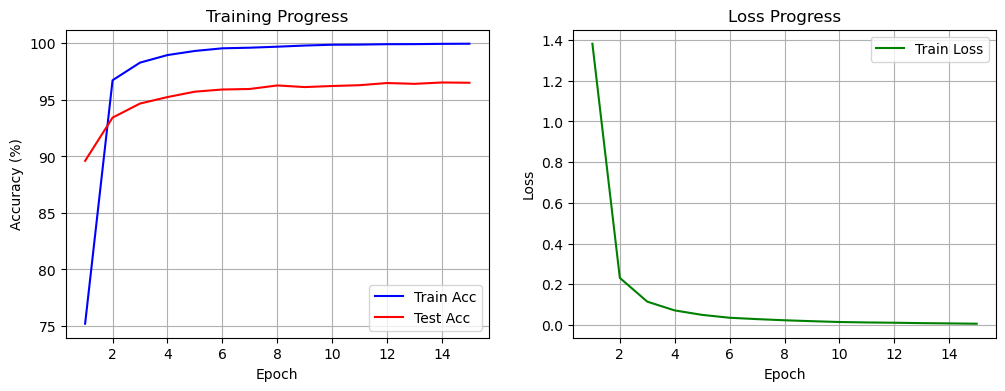

In [20]:
plt.figure(figsize=(12, 4))
        
# График 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b-', label='Train Acc')
plt.plot(epochs, test_accuracies, 'r-', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training Progress')
plt.grid(True)

# График 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'g-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Progress')
plt.grid(True)


In [21]:
from collections import defaultdict

model.eval()
correct_pred = defaultdict(int)
total_pred = defaultdict(int)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            total_pred[test_dataset.dataset.classes[labels[i]]] += 1
            if c[i]:
                correct_pred[test_dataset.dataset.classes[labels[i]]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * correct_count / total_pred[classname]
    print(f'{classname:12s}: {accuracy:.1f}%')


lisa_simpson: 96.1%
edna_krabappel: 96.3%
comic_book_guy: 97.1%
milhouse_van_houten: 97.2%
homer_simpson: 96.3%
apu_nahasapeemapetilon: 97.4%
martin_prince: 86.7%
moe_szyslak : 95.9%
waylon_smithers: 94.7%
ned_flanders: 97.2%
rainier_wolfcastle: 100.0%
abraham_grampa_simpson: 96.8%
principal_skinner: 98.3%
sideshow_mel: 75.0%
marge_simpson: 96.0%
nelson_muntz: 93.5%
charles_montgomery_burns: 96.2%
kent_brockman: 99.1%
krusty_the_clown: 97.6%
lenny_leonard: 98.5%
sideshow_bob: 99.4%
chief_wiggum: 97.8%
bart_simpson: 98.5%
barney_gumble: 84.2%
agnes_skinner: 71.4%
ralph_wiggum: 95.5%
groundskeeper_willie: 96.7%
selma_bouvier: 85.7%
carl_carlson: 100.0%
patty_bouvier: 91.7%
maggie_simpson: 76.2%
snake_jailbird: 76.9%
mayor_quimby: 97.6%
otto_mann   : 100.0%
professor_john_frink: 92.3%
cletus_spuckler: 77.8%
fat_tony    : 100.0%
gil         : 83.3%
troy_mcclure: 50.0%
lionel_hutz : 100.0%
miss_hoover : 100.0%
